In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/usr/local/lib/python3.8/site-packages')
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random

Reading Data

In [3]:
%cd /content/drive/MyDrive/Artificial Intelligence/Assignment3
data=pd.read_csv("dataset.csv")
data.drop(columns=data.columns[3],inplace=True) #drop the column with time
data=data.sample(n=1000) #randomly choose 1000 rows as data as very huge (35k+ instances)
data

/content/drive/MyDrive/Artificial Intelligence/Assignment3


,SystemCodeNumber,Capacity,Occupancy
2663,BHMBCCSNH01,863,135
26710,Others-CCCPS119a,2803,548
17579,BHMNCPNST01,485,307
1151,BHMBCCMKT01,577,420
31474,Others-CCCPS202,2937,1277
...,...,...,...
2228,BHMBCCPST01,317,186
28278,Others-CCCPS133,4675,958
23850,NIA Car Parks,1268,264
21858,Bull Ring,3053,1467


## K-Means Clustering

In [4]:
#this dataframe will only have attributes
data2=copy.deepcopy(data)
data2.drop(columns=data2.columns[0], inplace=True)

In [5]:
# Assign every training example x^(i) to its closest centroid, given the current centroid positions
def find_closest_centroids(X, centroids):
    '''returns the array of assigned clusters to each example ''' 
    m = X.shape[0] # no of datappints
    k = centroids.shape[0]  #division size
    idx = np.zeros(m) # array to assign the centriod
    # print(m)
    for i,point in enumerate(X):
      distances=[]
      for c in centroids:
        distances.append(math.sqrt(sum([(a-b)**2 for a,b in zip (point,c)])))
      idx[i]=int( np.argmin(distances) )
    return idx

In [6]:
# Update Centroids
def compute_centroids(X, idx, k):
    m, n = X.shape
    dictionary={}
    count=0
    centroids = np.zeros((k, n))  #3*4
    '''Return Updated Values of all K centroids'''
    total=np.zeros(k)
    for i, point in enumerate(X):
      index= int(idx[i])
      total[index]+=1 # number of points in that cluster +=1
      for xyz in range(n):
        centroids[index][xyz]+=point[xyz] #total for first dimension
  
    
    for i in range(k):
      for j in range(n):
        centroids[i][j]=centroids[i][j]/total[i]


    
    return centroids    

In [7]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        # find closest centroid
        idx = find_closest_centroids(X, centroids)
        #update centroids
        centroids = compute_centroids(X, idx, k)
    
    return idx, centroids

In [8]:
X=data2.to_numpy()

In [23]:
k=3
total=1000
rangex=np.linspace(0, total, k+1)
initial_centroids=[]
for i in range(k):
  print(int(rangex[i+1]))
  initial_centroids.append(X[random.randint(int(rangex[i]),int(rangex[i+1]))])
initial_centroids=np.array(initial_centroids)
print(initial_centroids)
idx, centroids = run_k_means(X, initial_centroids, 2000)# use 2000 iterations to perform clustering
print(centroids)

333
666
1000
[[1194  605]
 [2009 1292]
 [ 687  442]]
[[2622.89952153 1022.02392344]
 [4193.31325301 2489.93975904]
 [ 729.46186441  354.74576271]]


In [24]:
k_MeanCluster=[]
for i in range(k):
  k_MeanCluster.append(X[np.where(idx == i)[0],:])
k_MeanCluster=np.array(k_MeanCluster, dtype=object)

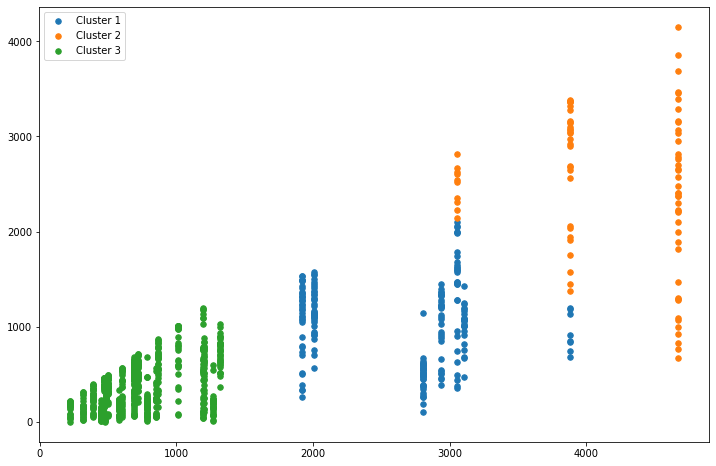

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
for i in range(k):
  name="Cluster "+str(i+1)
  ax.scatter(k_MeanCluster[i][:,0], k_MeanCluster[i][:,1], s=30, cmap='viridis', label=name)
ax.legend()


## DB Index

In [9]:
X=data2.to_numpy();

In [29]:
def getDBIndex(X, idx,k):
  R=np.zeros((k,k))
  for i in range(0,k):
    for j in range(0,k):
      if (i!=j):
        clusteri=X[np.where(idx==i)]
        clusterj=X[np.where(idx==j)]
        sumi=0;
        sumj=0;
        for p in clusteri:
          u=centroids[i]
          v=p
          sumi+=math.sqrt(sum([(a-b)**2 for a,b in zip (u,v)]))
        for p in clusterj:
          u=centroids[j]
          v=p
          sumj+=math.sqrt(sum([(a-b)**2 for a,b in zip (u,v)]))
        vari=sumi/float(len(clusteri))
        varj=sumj/float(len(clusterj))
        diff=math.sqrt(sum([(a-b)**2 for a,b in zip (centroids[i],centroids[j])]))
        R[i][j]=(vari+varj)/diff
  totalsum=0
  # print(R)
  for i in range(k):
    # print("Max of cluster", i, "is", max(R[i]))
    totalsum+=max(R[i])
  DB=totalsum/float(k)
  return DB
  
print("The DB Index when Number of clusters are",k,"is",getDBIndex(X,idx,k))


The DB Index when Number of clusters are 3 is 0.6452330833685509


## KNN Classification

In [10]:
def splitTrainingTest(XY):
  df=copy.deepcopy(XY)
  df=df.sample(frac=1)
  Y=df.to_numpy();
  t=int((80*1000)/100)
  training=Y[0:t,:]
  testing=Y[t:1000, :]
  return training, testing

training,testing=splitTrainingTest(data)
print("Training size is", len(training))
print("Testing size is", len(testing))


Training size is 800
Testing size is 200


In [11]:
def getKClosest(k, training, datapoint):
  distances=[]
  for t in training:
    m, n = training.shape
    x=t[1:n] #dont need the first column which is the label for calculating distance
    y=datapoint[0:n-1]  #the datapoint needed will have one column less than training as it doesnt have labels
    distance=math.sqrt(sum([(a-b)**2 for a,b in zip (x,y)]))
    distances.append((distance, t))
  sortedarr = sorted(distances, key=lambda x: x[0])
  # print(sortedarr)
  result=[]
  for i,d in enumerate(sortedarr):
    if (i<k):
      result.append(d)
    else:
      break
  return result


In [12]:
def getClass(closest):
  options=[]
  for d in closest:
    if d[1][0] not in options:
      options.append(d[1][0])
  frequency=np.zeros(len(options))
  for neighbour in closest:
    frequency[options.index(neighbour[1][0])]+=1
  return options[np.argmax(frequency)]

In [13]:
def knnAlgorithm(k, training, datapoint):
  closest=getKClosest(k, training, datapoint)
  return getClass(closest)

In [14]:
actual=[]
predicted=[]
for t in testing:
  m,n=testing.shape
  datat=t[1:n] #remove the labels for now
  actual.append(t[0:1]) #save the labels separately
  predicted.append(knnAlgorithm(3,training, datat))

for i, a in enumerate(actual):
  print("Actual class is ", a)
  print("Predicted class is ", predicted[i])

Actual class is  ['BHMBRCBRG03']
Predicted class is  BHMBRCBRG03
Actual class is  ['BHMBCCSNH01']
Predicted class is  BHMBCCSNH01
Actual class is  ['BHMNCPLDH01']
Predicted class is  BHMNCPLDH01
Actual class is  ['BHMBCCMKT01']
Predicted class is  BHMBCCMKT01
Actual class is  ['Others-CCCPS133']
Predicted class is  Others-CCCPS133
Actual class is  ['BHMNCPNST01']
Predicted class is  BHMNCPNST01
Actual class is  ['NIA Car Parks']
Predicted class is  NIA Car Parks
Actual class is  ['NIA Car Parks']
Predicted class is  NIA Car Parks
Actual class is  ['NIA South']
Predicted class is  NIA South
Actual class is  ['BHMNCPLDH01']
Predicted class is  BHMNCPLDH01
Actual class is  ['Shopping']
Predicted class is  Shopping
Actual class is  ['BHMNCPHST01']
Predicted class is  BHMNCPHST01
Actual class is  ['NIA South']
Predicted class is  NIA South
Actual class is  ['BHMMBMMBX01']
Predicted class is  Broad Street
Actual class is  ['BHMBRCBRG02']
Predicted class is  BHMBRCBRG02
Actual class is  ['Oth

## Evaluation Metrics

In [15]:
#form confusion matrix
def getMatrix(actual, predicted):
  classNames=data.SystemCodeNumber.unique()
  matrix=pd.DataFrame(index=np.unique(actual), columns=np.unique(predicted))
  matrix=matrix.fillna(0)
  for i, actual in enumerate(actual):
      matrix[predicted[i]][actual]+=1 #rows are actual and columns are predicted
  return matrix
matrix=getMatrix(actual, predicted)
matrix

,BHMBCCMKT01,BHMBCCPST01,BHMBCCSNH01,BHMBCCTHL01,BHMBRCBRG01,BHMBRCBRG02,BHMBRCBRG03,BHMBRTARC01,BHMEURBRD01,BHMEURBRD02,BHMMBMMBX01,BHMNCPHST01,BHMNCPLDH01,BHMNCPNHS01,BHMNCPNST01,BHMNCPPLS01,BHMNCPRAN01,Broad Street,Bull Ring,NIA Car Parks,NIA South,Others-CCCPS105a,Others-CCCPS119a,Others-CCCPS133,Others-CCCPS135a,Others-CCCPS202,Others-CCCPS8,Others-CCCPS98,Shopping
BHMBCCMKT01,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBCCPST01,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBCCSNH01,0,0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBCCTHL01,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBRCBRG01,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBRCBRG02,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMBRCBRG03,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMEURBRD01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMEURBRD02,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BHMMBMMBX01,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0


In [17]:
classNames=data.SystemCodeNumber.unique()
TP=np.zeros(len(classNames))
TN=np.zeros(len(classNames))
FP=np.zeros(len(classNames))
FN=np.zeros(len(classNames))
for i,name in enumerate(classNames):
  for j,pred in enumerate(matrix.columns):
    for z,act in enumerate(matrix.index):
      if pred==act and name==pred and name==act:
        TP[i]+=matrix[pred][act]
      if pred!=name and act!=name:
        TN[i]+=matrix[pred][act]
      if pred==name and pred!=act and name!=act:
        FP[i]+=matrix[pred][act]
      if act==name and pred!=act and name!=pred:
        FN[i]+=matrix[pred][act]

accuracy=(np.sum(TP))/len(testing)
print("The accuracy of the classification is ", accuracy)

The accuracy of the classification is  0.9


In [19]:
scores=pd.DataFrame(columns=["Precision", "Recall","F1"], index=classNames)
for i,name in enumerate(classNames):
  if ((FN[i]==0 and TP[i]==0) or (TP[i]==0 and FP[i]==0)):
    scores["Precision"][name]=0
    scores["Recall"][name]=0
    scores["F1"][name]=0
  else:
    scores["Precision"][name]=TP[i]/float(TP[i]+FP[i])
    scores["Recall"][name]=TP[i]/float(TP[i]+FN[i])
    scores["F1"][name]=2*(scores["Precision"][name]*scores["Recall"][name])/float(scores["Recall"][name]+scores["Precision"][name])
scores

,Precision,Recall,F1
BHMBCCSNH01,1,0.833333,0.909091
Others-CCCPS119a,1,1,1
BHMNCPNST01,0.857143,0.857143,0.857143
BHMBCCMKT01,1,1,1
Others-CCCPS202,1,1,1
BHMNCPHST01,0.818182,0.9,0.857143
Others-CCCPS105a,1,1,1
Others-CCCPS98,0.833333,1,0.909091
Others-CCCPS8,1,1,1
BHMNCPLDH01,1,1,1


In [20]:
microPrecision=np.sum(TP)/float(np.sum(TP)+np.sum(FP))
print("The micro precision of the classfication is",microPrecision)

The micro precision of the classfication is 0.9


In [21]:
microRecall=np.sum(TP)/float(np.sum(TP)+np.sum(FN))
print("The micro recall of the classfication is",microRecall)

The micro recall of the classfication is 0.9


In [22]:
microF1=2*(microRecall*microPrecision)/float(microRecall+microPrecision)
print("The micro F1 of the classfication is",microF1)

The micro F1 of the classfication is 0.9


In [23]:
macroPrecision=scores['Precision'].sum()/len(scores['Precision'])
print("The macro precision of the classfication is",macroPrecision)

The macro precision of the classfication is 0.8285954785954787


In [24]:
macroRecall=scores['Recall'].sum()/len(scores['Recall'])
print("The macro recall of the classfication is",macroRecall)

The macro recall of the classfication is 0.8394179894179895


In [25]:
macroF1=scores['F1'].sum()/len(scores['F1'])
print("The macro F1 of the classfication is",macroF1)

The macro F1 of the classfication is 0.8237277537277539
